In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [13]:
import numpy as np
import pandas as pd
import xarray as xr

import fields
import model
import plot

%matplotlib inline

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30, 2)

In [4]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64("2016-08-01"), timedeltas
    )
ev = mf.empirical_variograms(vario_config)

In [10]:
mod = model.FullBivariateMatern()
mod.fit(ev)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022812,"(0.4, 3.5)"
1,sigma_22,1.111089,"(0.4, 3.5)"
2,nu_11,0.760991,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865811,"(0.2, 3.5)"
5,len_scale_11,366.403262,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.902093,"(100.0, 2000.0)"
8,nugget_11,0.057774,"(0.0, 0.2)"
9,nugget_22,0.025698,"(0.0, 0.2)"


In [11]:
mod.fit_result.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022812,"(0.4, 3.5)"
1,sigma_22,1.111089,"(0.4, 3.5)"
2,nu_11,0.760991,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865811,"(0.2, 3.5)"
5,len_scale_11,366.403262,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.902093,"(100.0, 2000.0)"
8,nugget_11,0.057774,"(0.0, 0.2)"
9,nugget_22,0.025698,"(0.0, 0.2)"


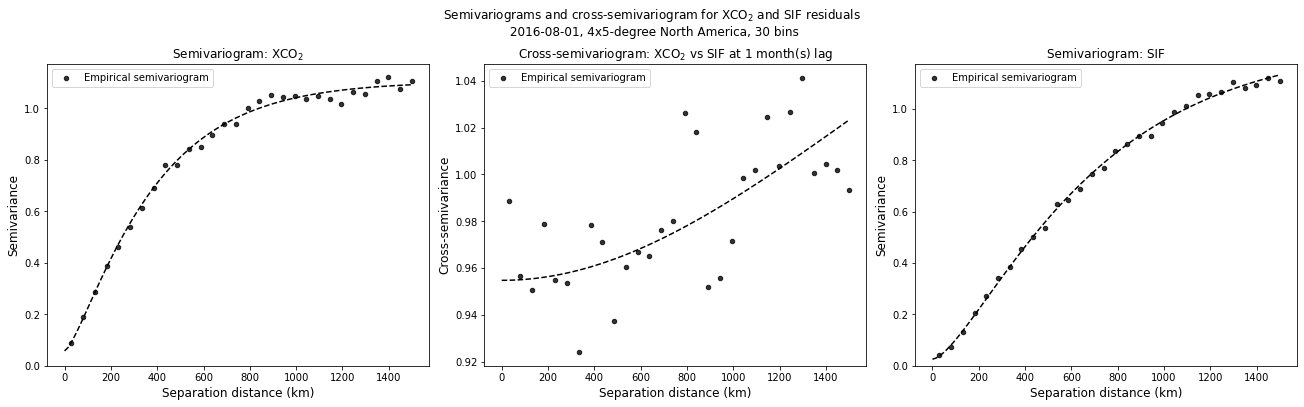

In [15]:
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"])